In [ ]:
!mamba install t-coffee mmseqs2 -y -q

In [1]:
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2023-10-02 13:25:00.851713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 13:25:00.921666: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 13:25:00.938369: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-02 13:25:01.333857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [10]:
# Your fasta file with unaligned sequences.

#train_filename = "test/data/egf.fasta"
train_filename = "../../snakeMSA/data/homfam/train/rhv"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "../../snakeMSA/data/homfam/refs/rhv"

# The number of independently trained models.
num_models = 10

HMM training supported by protein embeddings:

In [13]:
def align(filename, out_filename):
    config = Configuration.make_default(num_models)
    config["batch_size"] = Configuration.get_adaptive_batch_size_with_language_model
    # train a bit longer and with smaller updates than the default
    config["use_language_model"] = True
    config["learning_rate"] = 0.01
    config["epochs"] = [10, 4, 20]
    emission_init = [Initializers.EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
    if config["use_shared_embedding_insertions"]:
        insertion_init = [Initializers.EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
    else:
        insertion_init = [Initializers.make_default_insertion_init() for _ in range(config["num_models"])]
    config["emitter"] = Emitter.EmbeddingEmitter(config["lm_name"], 
                                            config["reduced_embedding_dim"],
                                            config["embedding_l2_match"], 
                                            config["embedding_l2_insert"], 
                                            emission_init=emission_init, 
                                            insertion_init=insertion_init,
                                            use_shared_embedding_insertions=config["use_shared_embedding_insertions"],
                                            frozen_insertions=config["frozen_insertions"],
                                            use_finetuned_lm=config["use_finetuned_lm"])
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = Training.embedding_model_generator
    batch_gen = Training.EmbeddingBatchGenerator(config["lm_name"], config["reduced_embedding_dim"], use_finetuned_lm=config["use_finetuned_lm"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp"),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 10 models on file rhv
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100000000

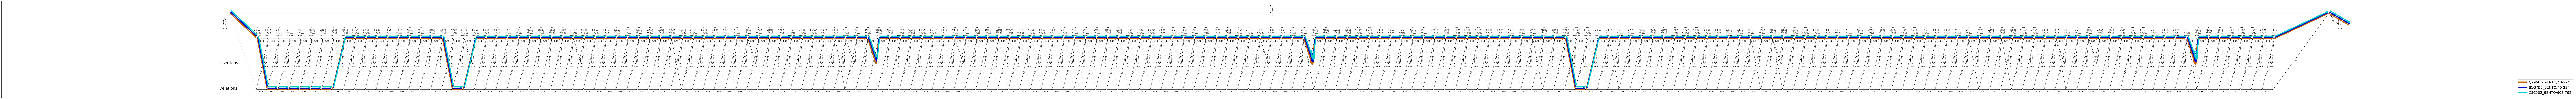

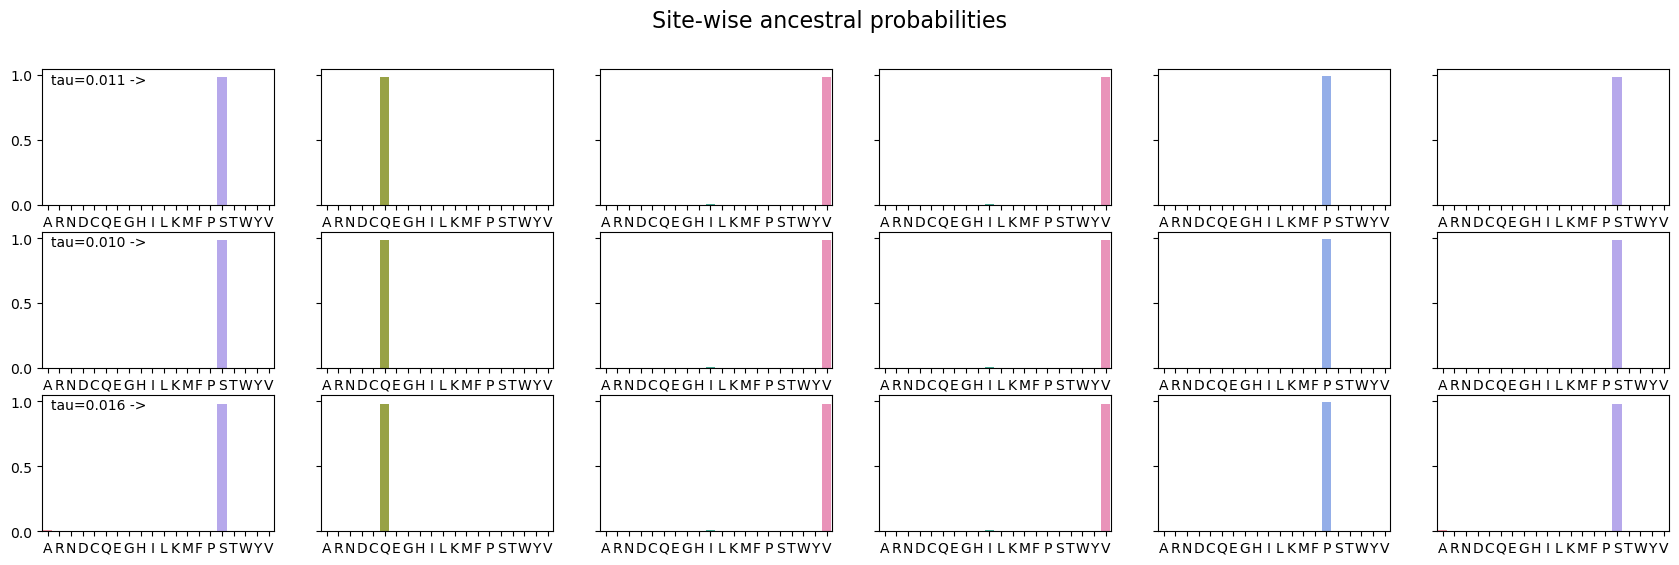

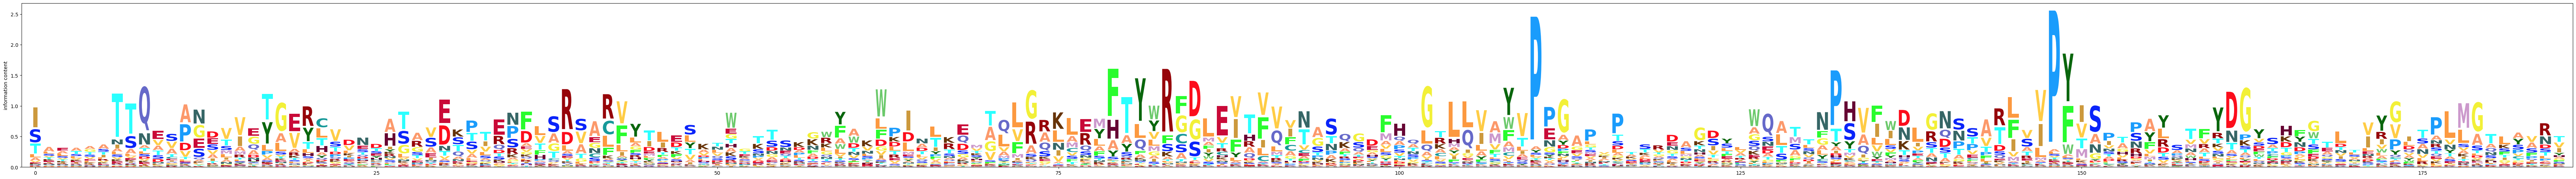

In [14]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [15]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1tme
HERE: 2mev
HERE: 1bbt
HERE: 1r1a
HERE: 4rhv
HERE: 2plv


In [16]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
rhv           6          33.1    70.0 [100.0]   [20998]


In [3]:
import os

path = "../../snakeMSA/data/homfam/train/"
out_path = "results/homfam/"
os.makedirs(out_path, exist_ok=True)
for file in os.listdir(path):
    alignment_model = align(file, out_path+os.path.basename(file))

2023-09-30 13:31:41.177459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 13:31:42.720467: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-30 13:31:43.511750: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 13:31:46.103047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

AttributeError: module 'learnMSA.msa_hmm' has no attribute 'emit'